In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
#https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
import json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
sw_nltk.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
import re
import spacy
import os

from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_val_score, )
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tomotopy import HDPModel

#from lda_classification.model import TomotopyLDAVectorizer
#from lda_classification.preprocess.spacy_cleaner import SpacyCleaner
import gensim
import gensim.corpora as corpora
import pyLDAvis
#import pyLDAvis.gensim_models as gensim
pyLDAvis.enable_notebook()
#import pyLDAvis.gensim
import pickle 

from matplotlib import pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = 4 #Numbers of workers throughout the project
use_umap = False #make this True if you want to use UMAP for your visualizations
#min_df = 5 #Minimum number for document frequency in the corpus
#rm_top = 5 #Remove top n frequent words



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hhcansal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#lem for lemmatization, stem for stemmatizing
def preprocess(data, type="lem"):
    words = set(nltk.corpus.words.words())
    i = 0
    preprocessed_data = []
    for x in data:
        #Lowerize
        x = x.lower()
        #Eliminate special characters
        x = re.sub(r'\d+', '', x)
        x = re.sub(' +', ' ', x.translate ({ord(c): "" for c in "!@#$%^&*()[]{};:,./<>?\\|'`~-=_+"}).strip())
        
        #Eliminate stop words
        words = [word for word in x.split() if word not in sw_nltk] 
        x = " ".join(words)

        #Stemming / Lemmatizing
        words = word_tokenize(x)
        rootWords = []
        if type=='stem':
                ps = PorterStemmer()
                rootWords.append(ps.stem(w))
        else:
            for w in words:
                wordnet_lemmatizer = WordNetLemmatizer()
                rootWords.append(wordnet_lemmatizer.lemmatize(w))

        x = x.split(' ')
        #x = TreebankWordDetokenizer().detokenize(rootWords)

        nlp = spacy.load("en_core_web_sm")
        
        article = []
        for sent in x:
            doc = nlp(sent)
            j = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]
            
            if (j != []):
                #print(j)
                #print(j[0] in words)
                #print(j[0].isalpha())
                if((j[0] in words) or (j[0].isalpha())):
                    article.append(j[0])
        dropped_documents = []
        if article != []:
            preprocessed_data.append(article)
        else:
            dropped_documents.append(article)
            print('Dropped ', i)
        
        i = i + 1
        #print(article)
    return preprocessed_data, dropped_documents
        
    


#preprocess(['Hsf##123 14: . ; ,  45', 'Blu34%& 22', 'as fine as good', 'found, find, go, went', 'studies studying cries cry'])

In [3]:
#Carefull!!! Takes about 90 minutes! If you already have a model saved, then use the prep_arr() class!!!!


# Opening JSON file
f_queries = open('Queries_Labeled.json',)
f_collection = open('collection.json')
 
# returns JSON object as
# a dictionary
data_queries = json.load(f_queries)
data_collection = json.load(f_collection)

# Iterating through the json
# list
#for i in data['documents']:
#    print(i)

queries = data_queries['documents']
collection = data_collection['TREC']['DOC']
#print(len(queries))
#print(len(collection))

# Closing file
f_queries.close()
f_collection.close()

dropped_documents = []
dropped = []

prep_collection = []
for x in collection:
    prep_collection.append(x['text'])
prep_collection, dropped = preprocess(prep_collection)
dropped_documents.append(dropped)
dropped = []

prep_queries = []
for x in queries:
    prep_queries.append(x['text'])
prep_queries, drop = preprocess(prep_queries)
dropped_documents.append(dropped)
dropped = []

#print(prep_queries)
#print(prep_collection)

Dropped  1353
Dropped  7850


In [2]:
# Opening JSON file
f_queries = open('Queries_Labeled.json',)
f_collection = open('collection.json')
 
# returns JSON object as
# a dictionary
data_queries = json.load(f_queries)
data_collection = json.load(f_collection)

# Iterating through the json
# list
#for i in data['documents']:
#    print(i)

queries = data_queries['documents']
collection = data_collection['TREC']['DOC']
#print(len(queries))
#print(len(collection))

# Closing file
f_queries.close()
f_collection.close()

In [3]:
#Savable data array class


class prep_arr(object):
    def __init__(self, data_arr=[]):
        self.data_arr = data_arr

    def save(self, path):
        with open(path, 'wb') as outp:
            pickle.dump(self, outp, pickle.HIGHEST_PROTOCOL)

    def load(self, path):
        with open(path, 'rb') as inp:
            prep_arr_load = pickle.load(inp)
        self.data_arr = prep_arr_load.data_arr
    

In [5]:
#Crfeate querry collection ensemble
querries_collection_dataset = []
for x in prep_queries:
    querries_collection_dataset.append(x)
for x in prep_collection:
    querries_collection_dataset.append(x)

In [6]:
#Save cleaned arrays

arr_q = prep_arr(prep_queries)
arr_q.save("./cleaned_data/prep_queries.txt")
arr_c = prep_arr(prep_collection)
arr_c.save("./cleaned_data/prep_collection.txt")

arr_qc = prep_arr(querries_collection_dataset)
arr_qc.save("./cleaned_data/querries_collection_dataset.txt")

In [48]:
print(len(prep_queries))
print(len(prep_collection))
print(len(querries_collection_dataset))
print(len(dropped_documents))

50
7848
7898
3


In [4]:
#Load the saved arrays

load_q = prep_arr()
load_q.load("./cleaned_data/prep_queries.txt")
prep_queries = load_q.data_arr

load_c = prep_arr()
load_c.load("./cleaned_data/prep_collection.txt")
prep_collection = load_c.data_arr

load_qc = prep_arr()
load_qc.load("./cleaned_data/querries_collection_dataset.txt")
querries_collection_dataset = load_qc.data_arr

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

def detokenize(dataset):
    detokenized_dataset = []
    for t in dataset:
        text = ""
        for w in t:
            text = text + w + " "
        detokenized_dataset.append(text.rstrip())

    #print(detokenized_dataset)
    return detokenized_dataset

def tf_idf_cleaner(dataset, tf_idf_scores, min_score):
    clean_dataset = []
    dropped_documents = []
    i = 0
    for text in dataset:
        t = []
        for word in text:
            if word in tf_idf_scores.columns:
                score = tf_idf_scores.iloc[i][word]
                if (score >= min_score):
                    t.append(word)
        if t != []:
            clean_dataset.append(t)
        else:
            print('empty text on line ', i)
            dropped_documents.append(i)
        i = i + 1
    #print(clean_dataset)
    return clean_dataset, dropped_documents




def tf_idf(dataset, min_score=0):
    dataset_detokenized = detokenize(dataset)
    #vec=TfidfVectorizer(stop_words='english')
    ##Create Vectors
    #matrix=vec.fit_transform(dataset)
    #print("Feature Names n",vec.get_feature_names_out())
    #print(matrix[0].toarray())
    #print("Sparse Matrix n",matrix.shape,"n",matrix.toarray())


    countvectorizer = CountVectorizer(analyzer= 'word')
    tfidfvectorizer = TfidfVectorizer(analyzer='word')
    count_wm = countvectorizer.fit_transform(dataset_detokenized)
    tfidf_wm = tfidfvectorizer.fit_transform(dataset_detokenized)
    count_tokens = countvectorizer.get_feature_names()
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    df_countvect = pd.DataFrame(data = count_wm.toarray(),columns = count_tokens)
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

    #print("Count Vectorizer\n")
    #print(df_countvect)
    #print("\nTF-IDF Vectorizer\n")
    #print(df_tfidfvect)
    #df_tfidfvect.to_csv('tfidf.csv')

    if(min_score > 0):
        dataset, dropped_documents = tf_idf_cleaner(dataset,df_tfidfvect,min_score)

    return dataset, df_countvect, df_tfidfvect, dropped_documents

    #terms = countvectorizer.fit_transform(dataset_detokenized)
    #term_vectors  = countvectorizer.transform(dataset_detokenized)
    #print("Sparse Matrix form of test data : \n")
    #print(term_vectors.todense())

    #tfidf = TfidfTransformer(norm='l2')
    #term_vectors.todense()
    #tfidf.fit(term_vectors)
    #tf_idf_matrix = tfidf.transform(term_vectors)
    #print("\nVector of idf \n")
    #print(tfidf.idf_)
    #print("\nFinal tf-idf vectorizer matrix form :\n")
    #print(tf_idf_matrix.todense())

dropped_documents = []
querries_collection_dataset, df_countvect, df_tfidfvect, dropped = tf_idf(querries_collection_dataset, min_score=0.2)
dropped_documents.append(dropped)
prep_collection = querries_collection_dataset[50:]
prep_querries = querries_collection_dataset[:50]

In [10]:
print(len(dropped_documents))

3


In [7]:
# Create Dictionary
id2word = corpora.Dictionary(querries_collection_dataset)
# Create Corpus
texts = querries_collection_dataset
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


In [8]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"amplifier" + 0.009*"frequency" + 0.008*"electron" + 0.007*"filter" + '
  '0.007*"transistor" + 0.007*"information" + 0.006*"datum" + 0.005*"service" '
  '+ 0.005*"index" + 0.004*"design"'),
 (1,
  '0.011*"datum" + 0.010*"computer" + 0.008*"pulse" + 0.008*"public" + '
  '0.006*"library" + 0.006*"school" + 0.005*"information" + 0.005*"voltage" + '
  '0.004*"amplifier" + 0.004*"satellite"'),
 (2,
  '0.008*"catalogue" + 0.007*"electron" + 0.007*"wave" + 0.007*"system" + '
  '0.007*"network" + 0.006*"layer" + 0.006*"frequency" + 0.005*"language" + '
  '0.005*"noise" + 0.004*"book"'),
 (3,
  '0.025*"information" + 0.021*"system" + 0.013*"library" + 0.012*"circuit" + '
  '0.008*"field" + 0.007*"network" + 0.007*"service" + 0.006*"magnetic" + '
  '0.006*"method" + 0.005*"datum"')]


In [9]:
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    #LDAvis_prepared = gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.001550 -0.032919       1        1  30.390517
0     -0.045483  0.084591       2        1  25.136139
2     -0.054241 -0.058861       3        1  23.934418
1      0.098174  0.007189       4        1  20.538926, topic_info=             Term        Freq       Total Category  logprob  loglift
19    information  988.000000  988.000000  Default  30.0000  30.0000
15         system  829.000000  829.000000  Default  29.0000  29.0000
1227    catalogue  230.000000  230.000000  Default  28.0000  28.0000
0         circuit  446.000000  446.000000  Default  27.0000  27.0000
459         datum  472.000000  472.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
180      electron   54.219466  423.477162   Topic4  -5.8468  -0.4726
15         system   54.713501  829.565567   Topic4  -5.8377  -1.1359
7          method   46.934161  296.796775   Topic4  -5.9911  -0.2615
138     frequency   47.468036  414.328442   Topic4  -5.9798  -0.5838
484    collection   45.134193  177.489984   Topic4  -6.0302   0.2136

[362 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
262       1  0.035988  acquisition
262       2  0.053981  acquisition
262       3  0.719753  acquisition
262       4  0.197932  acquisition
2817      1  0.936946  aggregation
...     ...       ...          ...
1621      4  0.949396   workingset
2479      1  0.768076     workshop
2479      2  0.128013     workshop
2479      3  0.096009     workshop
3301      1  0.964501          zbb

[775 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [10]:
import math
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=prep_collection):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=querries_collection_dataset)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic_querries = df_dominant_topic[df_dominant_topic['Document_No'] < 50]
#print(df_dominant_topic_querries)

df_dominant_topic_querries = df_dominant_topic_querries[df_dominant_topic_querries['Text'].notna()]
df_dominant_topic_collection = df_dominant_topic[df_dominant_topic['Document_No'] >= 50]
df_dominant_topic_collection = df_dominant_topic_collection[df_dominant_topic_collection['Text'].notna()]

df_dominant_topic = df_dominant_topic[df_dominant_topic['Text'].notna()]

print(df_dominant_topic)
#print(df_dominant_topic_querries['Text'])

      Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0               0             2.0              0.8369   
1               1             1.0              0.5212   
2               2             3.0              0.7890   
3               3             3.0              0.7906   
4               4             2.0              0.4887   
...           ...             ...                 ...   
7893         7893             1.0              0.9457   
7894         7894             3.0              0.9447   
7895         7895             1.0              0.9359   
7896         7896             3.0              0.9330   
7897         7897             0.0              0.9478   

                                               Keywords  \
0     catalogue, electron, wave, system, network, la...   
1     datum, computer, pulse, public, library, schoo...   
2     information, system, library, circuit, field, ...   
3     information, system, library, circuit, field, ...   
4     catalogue, ele

In [15]:
print(len(df_dominant_topic_querries))
print(len(df_dominant_topic_collection))


50
7848


In [11]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9815   
1        1.0              0.9774   
2        2.0              0.9799   
3        3.0              0.9884   

                                                                                         Keywords  \
0  amplifier, frequency, electron, filter, transistor, information, datum, service, index, design   
1     datum, computer, pulse, public, library, school, information, voltage, amplifier, satellite   
2             catalogue, electron, wave, system, network, layer, frequency, language, noise, book   
3         information, system, library, circuit, field, network, service, magnetic, method, datum   

                                                                                   Representative Text  
0  [radio, astronomy, radio, astronomy, radio, astronomy, radiation, radio, radio, astronomy, radio...  
1  [file, file, datum, base, organization, file, organization, datum, base, base, file, structure, ...  
2  [synthetic, image, image, surface, model, image, image, model, surface, image, image, image, ter...  
3  [datum, communication, control, procedure, datum, communication, datum, communication, control, ...

In [68]:
pddf = pd.DataFrame({'Data':[0,1,2,3,4,5,6,7,8,9,10]})
print(pddf.iloc[:3])
print(pddf.iloc[3:])

   Data
0     0
1     1
2     2
    Data
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10


In [12]:
# Querries and Collection
## 50 + 7851 = 7901
# Dropped: 1353, 7850, 2857]

#print(df_countvect[1351:1354][0:4])

#print(df_countvect[1353:1355][0:4])

def restore_eliminated_rows(df, positions_tf_idf, positions_prep):
    if positions_tf_idf != []:
        for pos in positions_tf_idf:
            df1 = df.iloc[:pos]
            df3 = df.iloc[pos:]
            df2 = pd.DataFrame(columns = df_countvect.columns)
            df2.loc[0] = 0
            frames = [df1, df2, df3]
            df = pd.concat(frames).reset_index(drop=True)

    if positions_prep != []:
        print(positions_prep)
        for pos in positions_prep:
            df1 = df.iloc[:pos]
            df3 = df.iloc[pos:]
            df2 = pd.DataFrame(columns = df_countvect.columns)
            df2.loc[0] = 0
            frames = [df1, df2, df3]
            df = pd.concat(frames).reset_index(drop=True)

    return df

df_countvect_restored = restore_eliminated_rows(df_countvect, [], [1353, 7850])
df_tfidfvect_restored = restore_eliminated_rows(df_tfidfvect, [], [1353, 7850])
df_dominant_topic_restored = restore_eliminated_rows(df_dominant_topic, [2857], [1353, 7850])


print(len(df_countvect_restored))
print(len(df_tfidfvect_restored))
print(len(df_dominant_topic_restored))

[1353, 7850]
[1353, 7850]
[1353, 7850]
7900
7900
7901


In [33]:
df_test = pd.DataFrame({'Data':[1,2,3,4,5,6,7,8]})
print(df_test[2:3].index.values)

for x in df_test:
    print(x)

xyz = []
xyz.append([3, 0.79])
xyz.append([7, 0.55])
topic = 0
articles_topic = topics_articles[topics_articles['Dominant_Topic'] == topic]
print(articles_topic)


[2]
Data


NameError: name 'topics_articles' is not defined

In [34]:
print(collection)

[{'recordId': 0, 'text': 'digital computers in universities (part i) july, 1960\n    reeves, r. f. ca600702 jb march 20, 1978 9:20 pm'}, {'recordId': 2, 'text': 'using synthetic images to register real images with\n    surface models a number of image analysis tasks can benefit\n    from registration of the image with a model of the surface\n    being imaged. automatic navigation using visible light or radar\n    images requires exact alignment of such images with digital\n    terrain models. in addition, automatic classification of\n    terrain, using satellite imagery, requires such alignment to\n    deal correctly with the effects of varying sun angle and\n    surface slope. even inspection techniques for certain\n    industrial parts may be improved by this means. we achieve the\n    required alignment by matching the real image with a synthetic\n    image obtained from a surface model and known positions of the\n    light sources. the synthetic image intensity is calculated\n    u

In [56]:
import numpy.linalg as LA

a = np.array([1, 2])
b = np.array([-5, 4])

inner = np.inner(a, b)
norms = LA.norm(a) * LA.norm(b)

cos = inner / norms
print(cos)

[1. 2. 3. 4.]
[5. 6. 7. 8.]
70.0


In [65]:
import math

def dotproduct(v1, v2):
  #print(v1)
  #print(v2)
  x = sum((a*b) for a, b in zip(v1, v2))

  return x

def length(v):
  #print(v)
  v = np.array(v).astype('float')
  return np.sqrt(dotproduct(v, v))

def cos_angle(v1, v2):
  print(length(v1))
  print(length(v2))
  if((length(v1) != 0) & (length(v2) != 0)):
    return dotproduct(v1, v2) / (length(v1) * length(v2))
  else:
    return 0



def get_collection(q_vector, topic, query_ID):
  articles_topic = topics_articles[topics_articles['Dominant_Topic'] == topic].reset_index(drop=True)

  counter = 0
  document_ids = []
  document_cos_angle = []

  while counter < len(articles_topic):
    id = int(articles_topic.iloc[counter + 49]['Document_No'])
    
    id = collection[id]['recordId']
    document_ids.append(id)

    c_vect = df_countvect_restored.iloc[counter + 49].to_numpy()
    tfidf_vect = df_tfidfvect_restored.iloc[counter + 49].to_numpy()
    c_vector = []

    for x in range(len(c_vect)):
      c_vector.append(c_vect[x]*tfidf_vect)

    #print(q_vector)
    #print(c_vector)
    dot_product = np.dot(q_vector, c_vector)
    document_cos_angle.append(dot_product)
    #document_cos_angle.append(cos_angle(q_vector, c_vector))
    counter = counter + 1
    
  df_resultset = pd.DataFrame({'Query ID':[query_ID for i in range(len(document_ids))], 'Iteration': [iter for i in range(len(document_ids))], 'Dok.Nummer': document_ids, 'Score': document_cos_angle, 'System': [sysname for i in range(len(document_ids))]})
  df_resultset = df_resultset.sort_values('Score')
  df_resultset['Rang'] = [i for i in range(len(document_ids))]
  return df_resultset
 

df_results = pd.DataFrame({'Query ID', 'Iteration', 'Dok.Nummer', 'Rang', 'System'})
iter = 'Q0'
sysname = 'derigval_ansalcla_SKB'
topics_queries = df_dominant_topic_restored[:49].reset_index(drop=True)
topics_articles = df_dominant_topic_restored[50:].reset_index(drop=True)

i = 0
while i < len(queries):
  q_ID = queries[i]['recordId']
  q_vector = []
  
  c_vect = df_countvect_restored.iloc[i].to_numpy()
  tfidf_vect = df_tfidfvect_restored.iloc[i].to_numpy()
  for x in range(len(c_vect)):
    q_vector.append(c_vect[x]*tfidf_vect)

  topic = topics_queries.iloc[i]['Dominant_Topic']

  res = get_collection(q_vector, topic, q_ID)
  df_results.append(res.loc[:,['Query ID', 'Iteration', 'Dok.Nummer', 'Rang', 'Score', 'System']])
  #print(len(df_countvect_restored))
  #print(len(df_tfidfvect_restored))
  i = i + 1

print(df_results)


#dropped_documents = [1353, 7850, 2857]
#print(collection[:100])
#print('Queries ', len(queries))
#print('Collection ', len(collection))
#print('Querries + Collection ', len(querries_collection_dataset))
#print('Count Vectors ', len(df_countvect))
#print('tf-idf Vectors ', len(df_tfidfvect))

#print('Dropped Documents ', len(dropped_documents))

#print('Prep_collection ', len(prep_collection))
#print('Prep_Queries ', len(prep_querries))
#print('Dominant Topics ', len(df_dominant_topic))

#print(dropped_documents)

#print(len(df_countvect.columns))


#queries
#collection


#querries_collection_dataset (TFIDF Dataset)
#df_countvect
#df_tfidfvect
#dropped_documents

#prep_collection
#prep_querries

#df_dominant_topic

In [13]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=prep_collection):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=querries_collection_dataset)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0             0             2.0              0.8370   
1             1             1.0              0.5212   
2             2             3.0              0.7889   
3             3             3.0              0.7905   
4             4             2.0              0.4904   
..          ...             ...                 ...   
95           95             1.0              0.8573   
96           96             3.0              0.9321   
97           97             0.0              0.9545   
98           98             2.0              0.9201   
99           99             2.0              0.9734   

                                                                                          Keywords  \
0              catalogue, electron, wave, system, network, layer, frequency, language, noise, book   
1      datum, computer, pulse, public, library, school, information, voltage, amplifier, satellite   
2          information, system, library, circuit, field, network, service, magnetic, method, datum   
3          information, system, library, circuit, field, network, service, magnetic, method, datum   
4              catalogue, electron, wave, system, network, layer, frequency, language, noise, book   
..                                                                                             ...   
95     datum, computer, pulse, public, library, school, information, voltage, amplifier, satellite   
96         information, system, library, circuit, field, network, service, magnetic, method, datum   
97  amplifier, frequency, electron, filter, transistor, information, datum, service, index, design   
98             catalogue, electron, wave, system, network, layer, frequency, language, noise, book   
99             catalogue, electron, wave, system, network, layer, frequency, language, noise, book   

                                                                                                   Text  
0                                                               [transistor, phase, splitting, circuit]  
1                                             [determination, orbit, individual, meteor, radio, method]  
2                                 [article, text, format, system, get, system, example, tnroff, scribe]  
3   [psychology, information, seek, information, usefulness, user, behaviour, information, seek, beh...  
4                                                         [memory, management, aspect, operate, system]  
..                                                                                                  ...  
95  [datum, input, datum, input, computer, input, computer, user, value, computer, converse, user, i...  
96    [convention, cosmic, ray, convention, varenna, cosmic, ray, radiation, shower, cosmic, radiation]  
97  [cable, satellite, library, cable, library, library, cable, company, satellite, cable, library, ...  
98                            [campaign, aid, help, lobbyist, great, victory, creation, joint, funding]  
99  [compact, list, representation, garbage, compact, list, list, compact, list, representation, gar...  

[100 rows x 5 columns]

In [19]:
print(len(df_dominant_topic))

7848


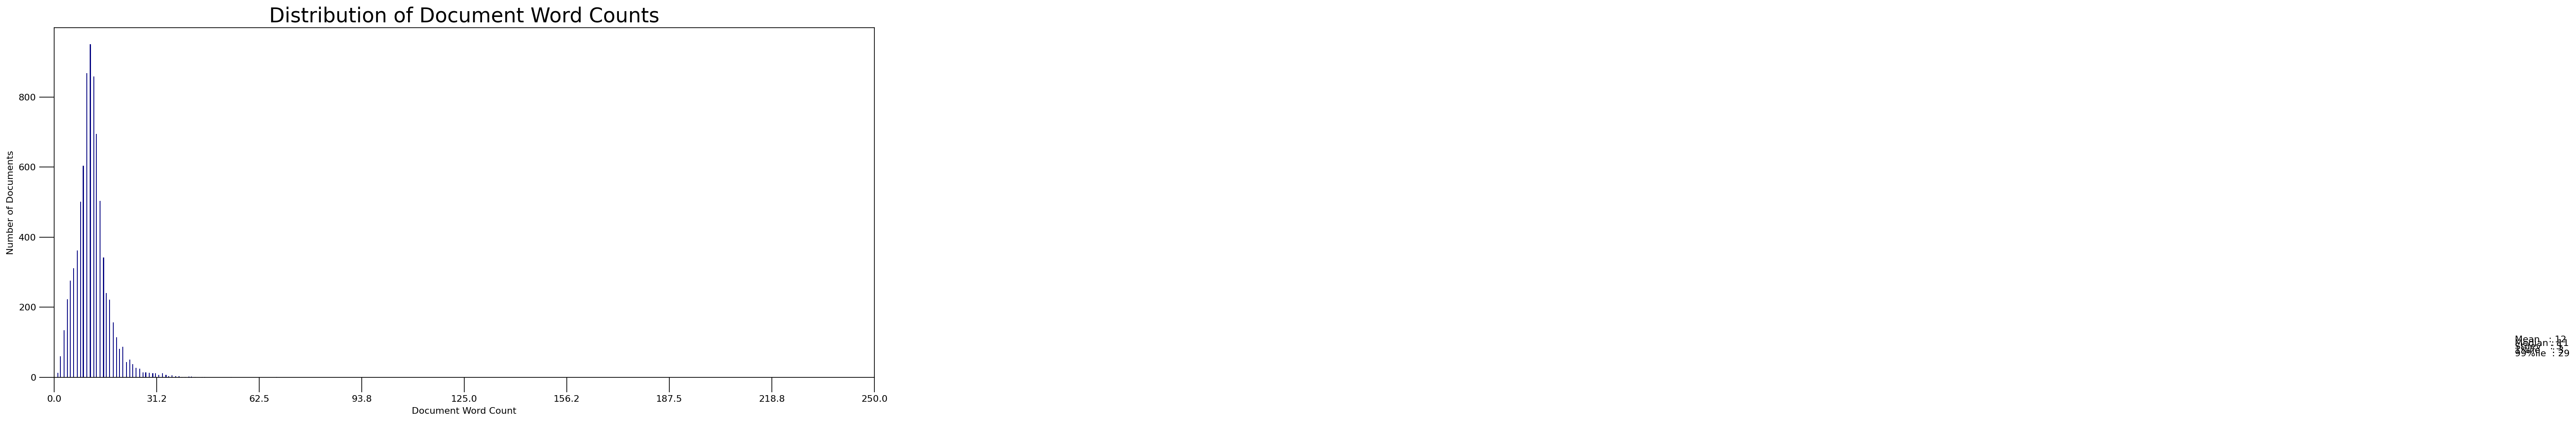

In [14]:
#print([len(d) for d in df_dominant_topic.Text])
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 250, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 250), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,250,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

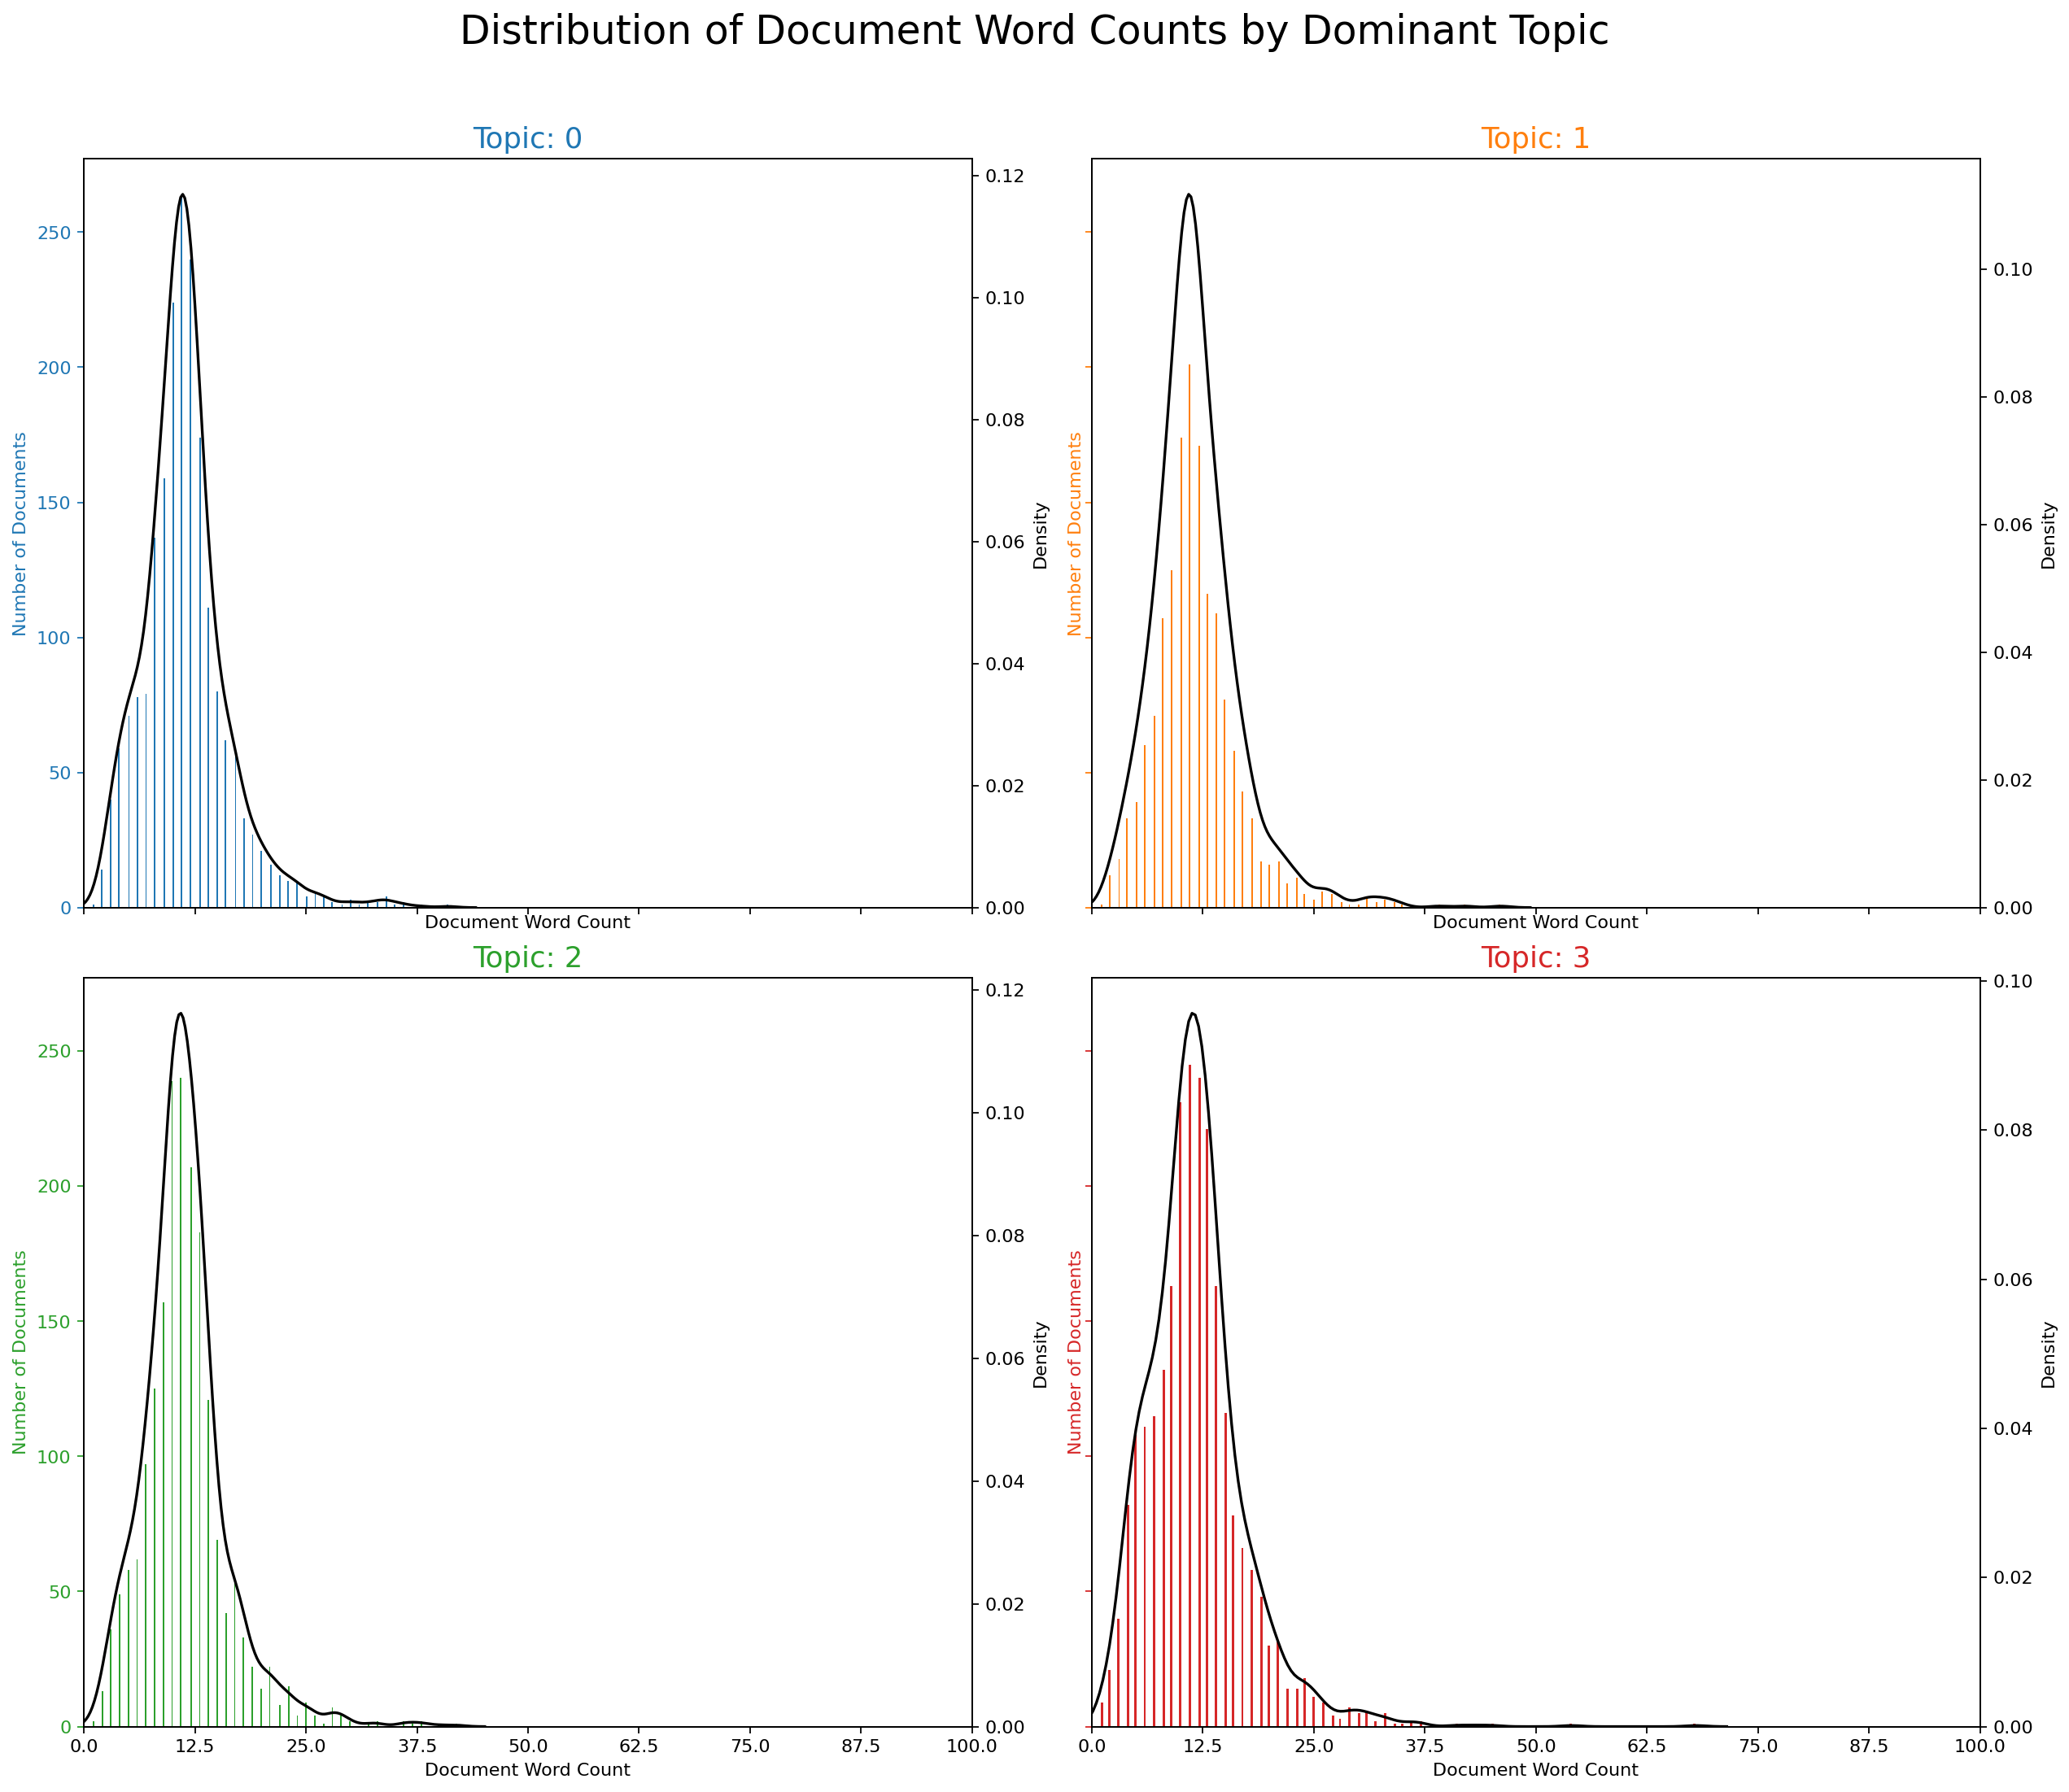

In [15]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(round(num_topics/2),2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 250, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

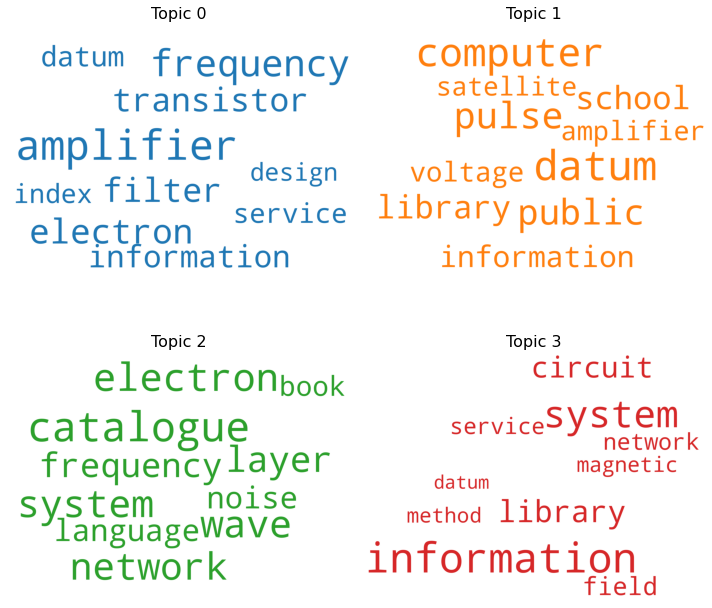

In [16]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(round(num_topics/2), 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\TEMP/ipykernel_21860/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_21860/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_21860/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\TEMP/ipykernel_21860/1168647641.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


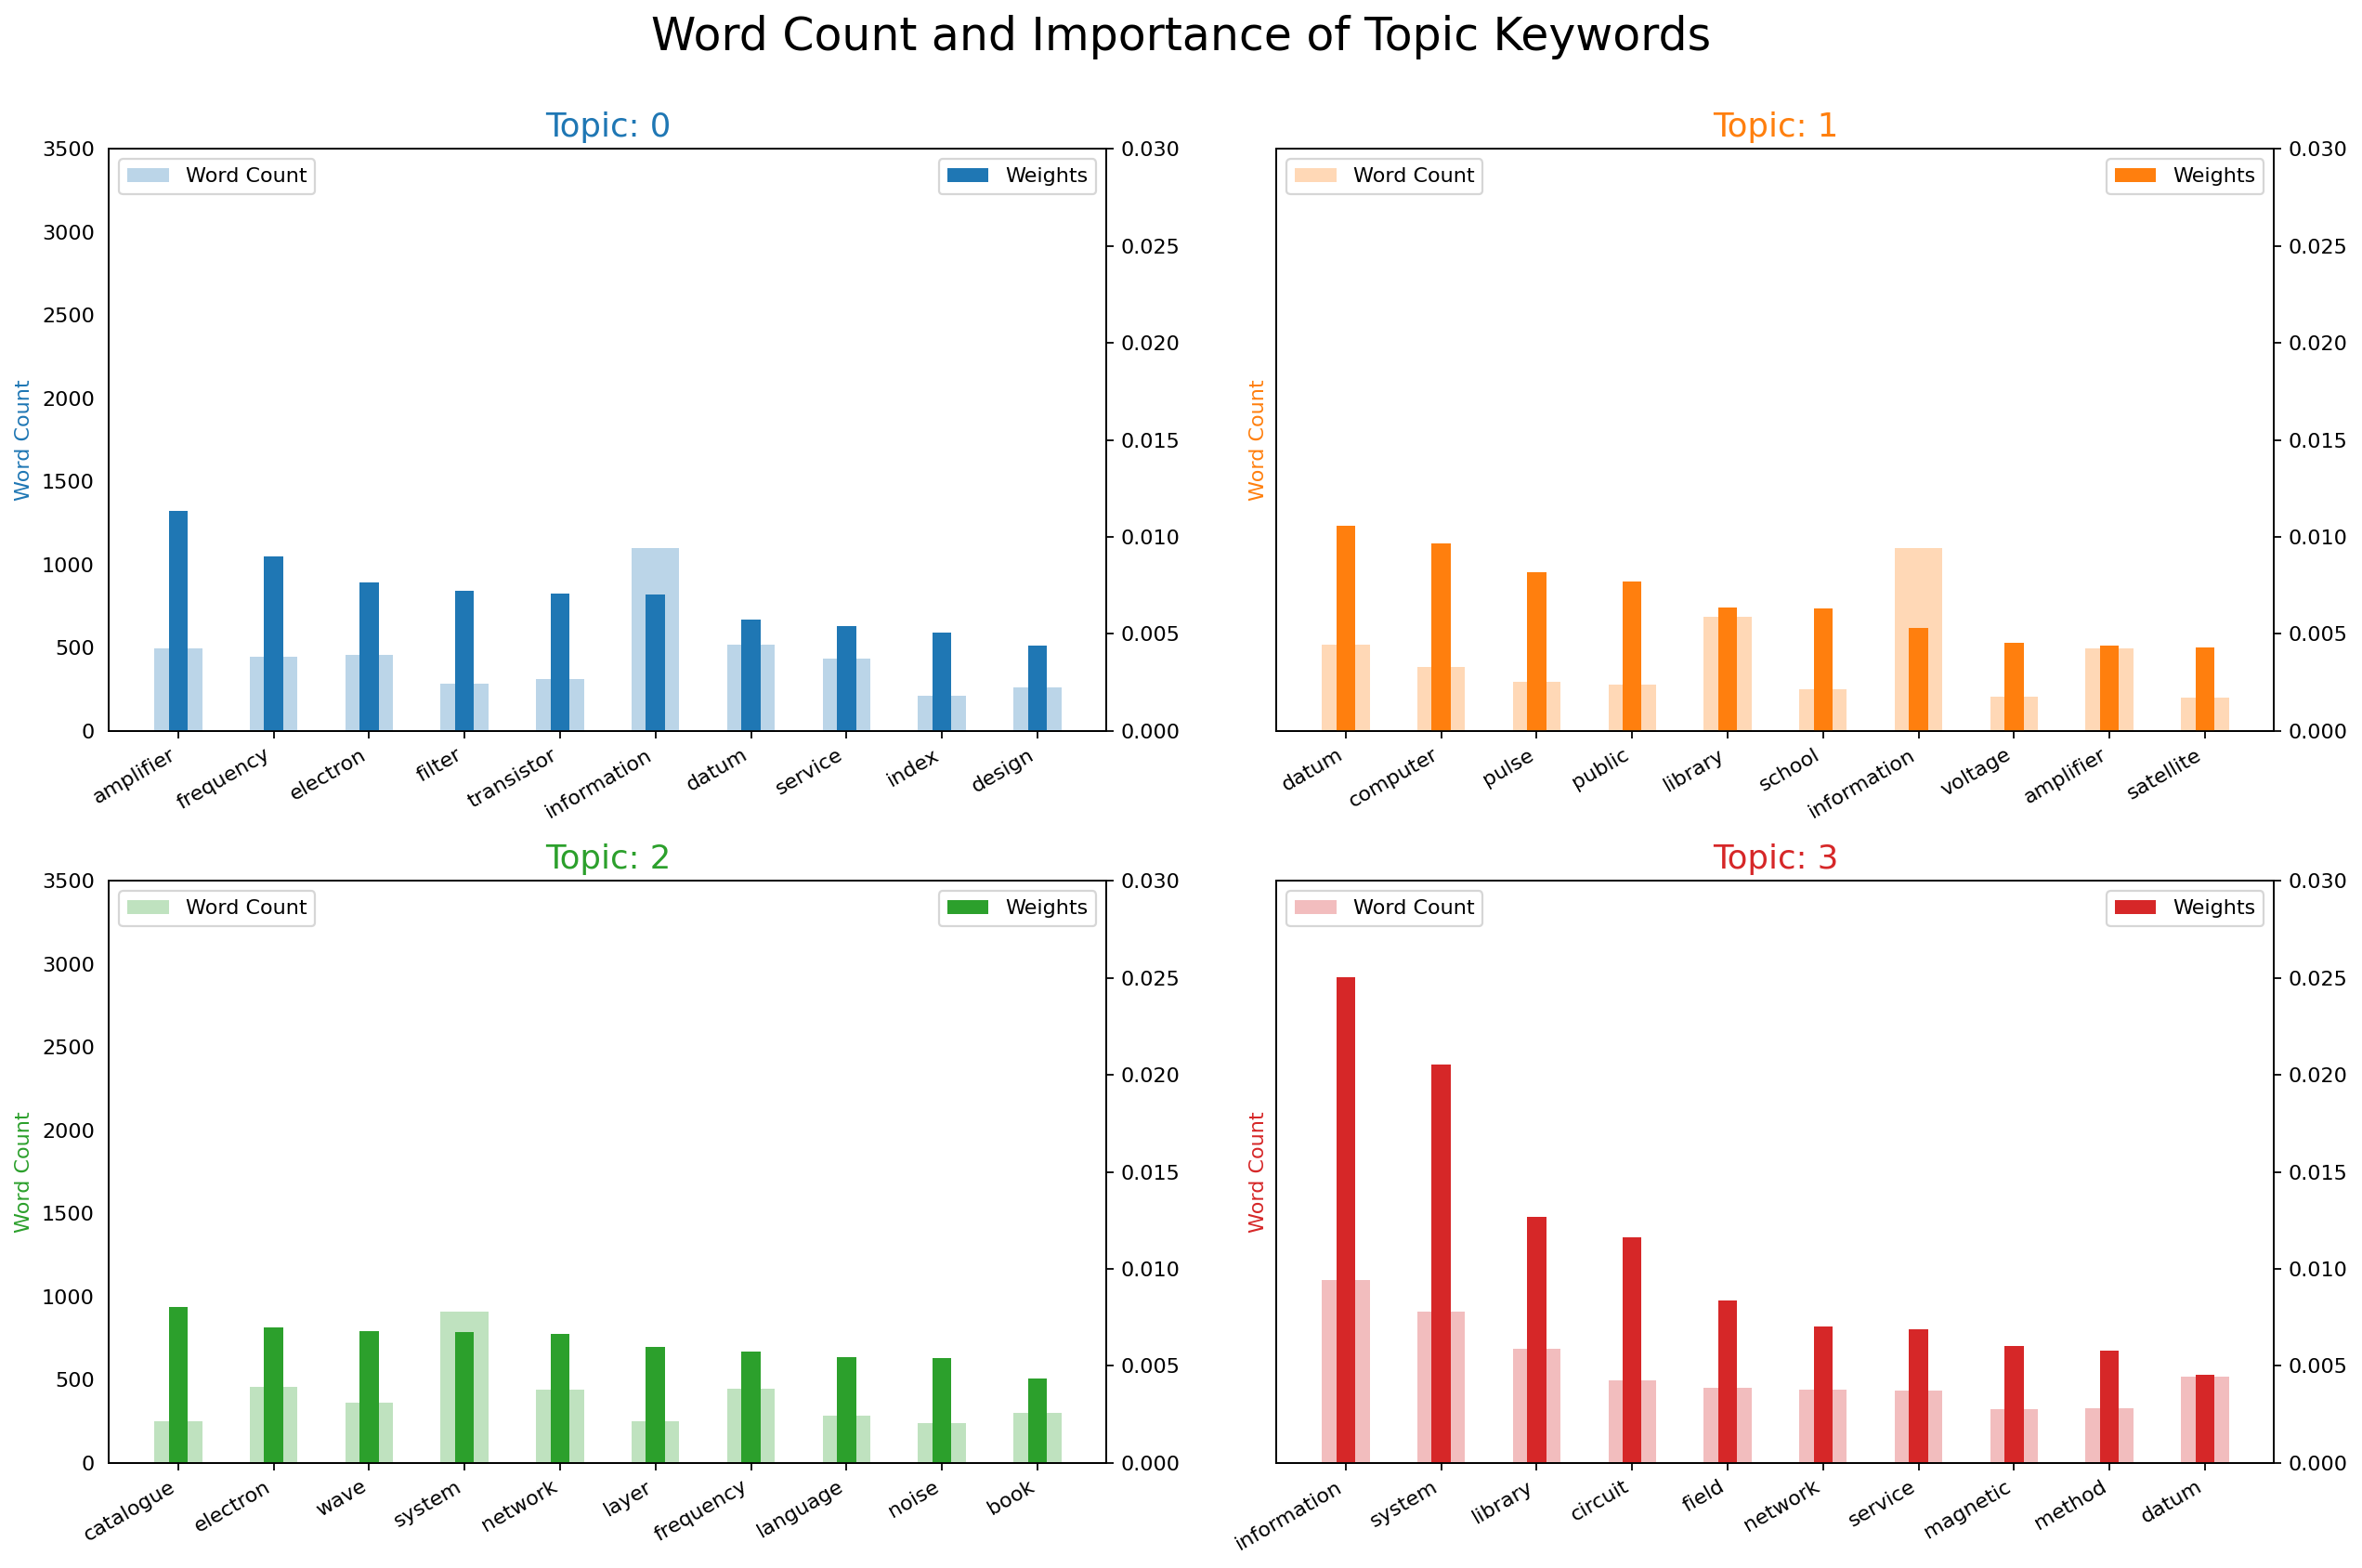

In [17]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in prep_collection for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(round(num_topics/2), 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [18]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
#print(enumerate(lda_model[corpus]))
for i, row_list in enumerate(lda_model[corpus]):
    #print(i, row_list)
    topic_weights.append([w for w in row_list[0]])
#topic_weights = np.array(topic_weights)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
print(arr)
# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
#tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[[0.         0.05450195]
 [0.         0.03762538]
 [0.         0.15707958]
 ...
 [0.         0.02132991]
 [0.         0.02328873]
 [0.         0.9477756 ]]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7898 samples in 0.007s...
[t-SNE] Computed neighbors for 7898 samples in 0.130s...


C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 7898
[t-SNE] Computed conditional probabilities for sample 2000 / 7898
[t-SNE] Computed conditional probabilities for sample 3000 / 7898
[t-SNE] Computed conditional probabilities for sample 4000 / 7898
[t-SNE] Computed conditional probabilities for sample 5000 / 7898
[t-SNE] Computed conditional probabilities for sample 6000 / 7898
[t-SNE] Computed conditional probabilities for sample 7000 / 7898
[t-SNE] Computed conditional probabilities for sample 7898 / 7898
[t-SNE] Mean sigma: 0.000048


C:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.453106
[t-SNE] KL divergence after 1000 iterations: 0.384861


Loading BokehJS ...

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

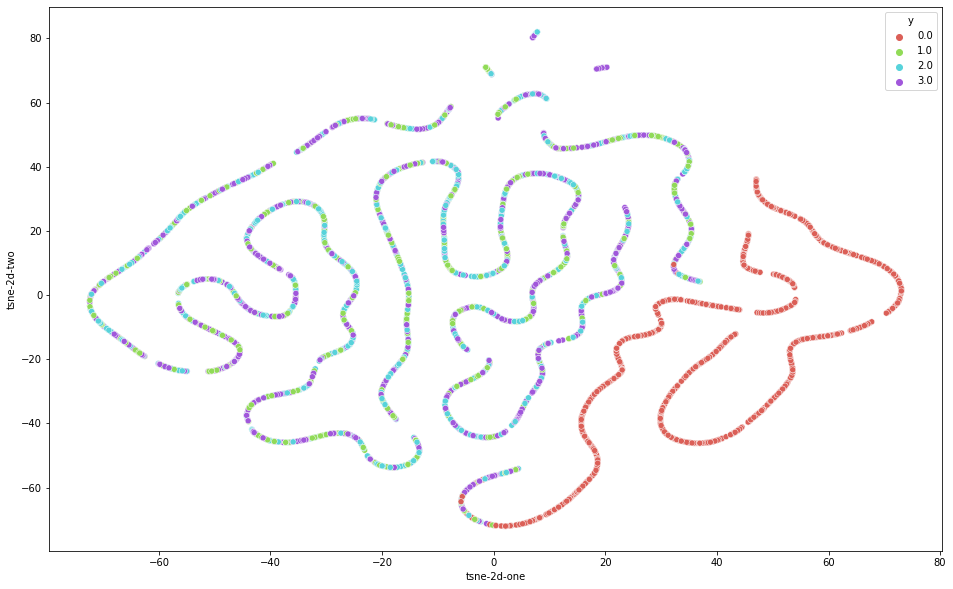

In [19]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_lda[:,0]
df_subset['tsne-2d-two'] = tsne_lda[:,1]
df_subset['y'] = df_dominant_topic['Dominant_Topic']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", num_topics),
    data=df_subset,
    legend="full",
    alpha=0.99
)
